The code has been written with assistance from ChatGPT

Regression model:

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

# Loading data
df = pd.read_csv("HR_data.csv")

# Define input and target variables
X = df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max']]
y = df["Frustrated"]
# Ensure grouped recordings for CV split (every individual has 12 recordings)
groups = df["Individual"] 

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define GroupKFold with 5 folds ---
gkf = GroupKFold(n_splits=5)

# Evaluate with cross_val_score using negative RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)
scores = cross_val_score(model, X_scaled, y, cv=gkf, groups=groups, scoring='neg_root_mean_squared_error')

# Report results:
print("RMSE per fold:", -scores)
print("Mean RMSE:", -scores.mean())



RMSE per fold: [2.36295248 1.86319631 2.18260496 2.32006046 1.57940251]
Mean RMSE: 2.06164334567567


For hvert outer fold: 
- træning: der trænes 100 træer
- testing: de trænede modeller får nu test dataen, og de skal hver give deres bud
- output: combiner budene fra de 100 træer, så får du final output
- RMSE: beregn fejlen mellem dit final bud og den faktiske værdi, og tag kvadratroden af det

Gentag for alle outer folds

In [30]:
# Confidence interval via percentiles
ci_lower = np.percentile(-scores, 2.5)
ci_upper = np.percentile(-scores, 97.5)

print("Cross-validated RMSE per fold:", -scores)
print(f"Mean RMSE: {np.mean(-scores):.3f}")
print(f"95% CI for RMSE (via CV folds): ({ci_lower:.3f}, {ci_upper:.3f})")

Cross-validated RMSE per fold: [2.36295248 1.86319631 2.18260496 2.32006046 1.57940251]
Mean RMSE: 2.062
95% CI for RMSE (via CV folds): (1.608, 2.359)


Classifier

Columns: Index(['Unnamed: 0', 'HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max',
       'HR_AUC', 'Round', 'Phase', 'Individual', 'Puzzler', 'Frustrated',
       'Cohort'],
      dtype='object')

Classification Report:
              precision    recall  f1-score   support

         Low       0.71      0.83      0.77       121
      Medium       0.22      0.12      0.15        42
        High       0.00      0.00      0.00         5

    accuracy                           0.63       168
   macro avg       0.31      0.32      0.31       168
weighted avg       0.56      0.63      0.59       168



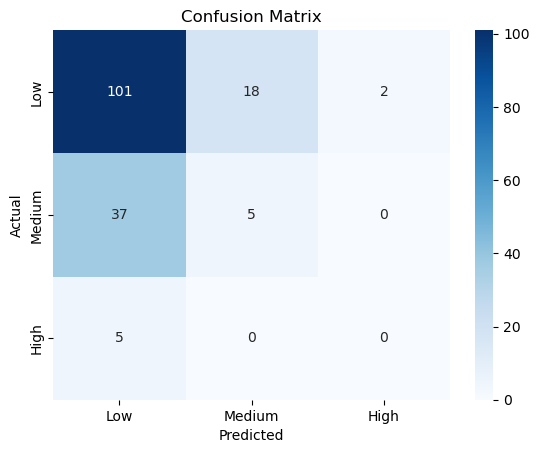

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("HR_data.csv")

# --- Check your column names ---
print("Columns:", df.columns)

# --- Strip column names in case there are spaces ---
df.columns = df.columns.str.strip()

# --- Define feature and target columns ---
X = df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max']]
groups = df["Individual"]

# --- Bin Frustration into 3 classes ---
def bin_frustration(val):
    if val <= 3:
        return 0  # Low
    elif val <= 6:
        return 1  # Medium
    else:
        return 2  # High

y = df["Frustrated"].apply(bin_frustration)

# --- Optional: Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Define the classifier ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# --- Grouped Cross-validation ---
gkf = GroupKFold(n_splits=5)

# --- Get cross-validated predictions ---
y_pred = cross_val_predict(clf, X_scaled, y, cv=gkf, groups=groups)

# --- Evaluation ---
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["Low", "Medium", "High"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
import numpy as np

# --- Model and setup ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
gkf = GroupKFold(n_splits=5)

# --- Storage for fold-wise scores ---
f1_scores = []
precisions = []
recalls = []

# --- Manual CV loop ---
for train_idx, test_idx in gkf.split(X_scaled, y, groups=groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred_fold = clf.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred_fold, average='weighted'))
    precisions.append(precision_score(y_test, y_pred_fold, average='weighted'))
    recalls.append(recall_score(y_test, y_pred_fold, average='weighted'))

# --- Compute 95% confidence intervals using percentiles ---
def ci(arr):
    return np.percentile(arr, [2.5, 97.5])

print(f"\nCross-validated (fold-wise) 95% Confidence Intervals:")
print(f"Precision: {np.mean(precisions):.3f} (95% CI: {ci(precisions)[0]:.3f} – {ci(precisions)[1]:.3f})")
print(f"Recall:    {np.mean(recalls):.3f} (95% CI: {ci(recalls)[0]:.3f} – {ci(recalls)[1]:.3f})")
print(f"F1 Score:  {np.mean(f1_scores):.3f} (95% CI: {ci(f1_scores)[0]:.3f} – {ci(f1_scores)[1]:.3f})")



c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bruger\Mi


Cross-validated (fold-wise) 95% Confidence Intervals:
Precision: 0.559 (95% CI: 0.492 – 0.705)
Recall:    0.633 (95% CI: 0.586 – 0.692)
F1 Score:  0.589 (95% CI: 0.526 – 0.697)


c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcula

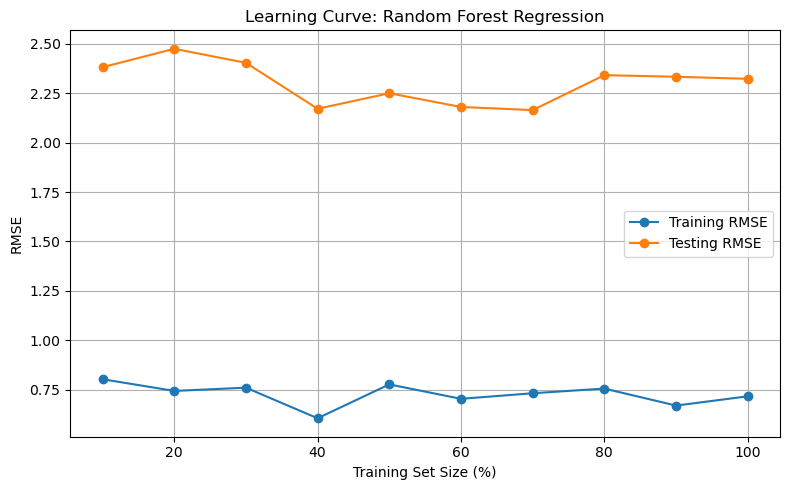

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("HR_data.csv")
df.columns = df.columns.str.strip()

X =  df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max']]
y = df["Frustrated"]
groups = df["Individual"]

# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Store average training/testing errors ---
train_errors = []
test_errors = []
sizes = np.linspace(0.1, 1.0, 10)

# --- Split once into train/test using GroupShuffleSplit logic ---
unique_ids = groups.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_idx = df[groups.isin(train_ids)].index
test_idx = df[groups.isin(test_ids)].index

X_train, y_train = X_scaled[train_idx], y.iloc[train_idx]
X_test, y_test = X_scaled[test_idx], y.iloc[test_idx]

# --- Loop over increasing training set sizes ---
for frac in sizes:
    subset_size = int(frac * len(train_idx))
    subset_idx = np.random.choice(train_idx, size=subset_size, replace=False)

    X_sub = X_scaled[subset_idx]
    y_sub = y.iloc[subset_idx]

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_sub, y_sub)

    # Predict and compute RMSE
    y_train_pred = model.predict(X_sub)
    y_test_pred = model.predict(X_test)

    rmse_train = mean_squared_error(y_sub, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    train_errors.append(rmse_train)
    test_errors.append(rmse_test)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sizes * 100, train_errors, label="Training RMSE", marker='o')
plt.plot(sizes * 100, test_errors, label="Testing RMSE", marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Data distribution

In [22]:
# Count the number of each raw frustration level
frustration_counts = y.value_counts().sort_index()
print("Frustration level counts:")
print(frustration_counts)


Frustration level counts:
Frustrated
0    29
1    45
2    31
3    16
4    23
5    14
6     5
7     2
8     3
Name: count, dtype: int64


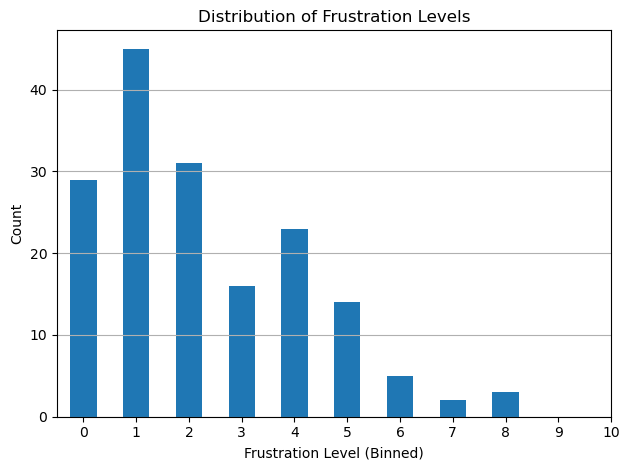

In [31]:
import matplotlib.pyplot as plt

binned_counts.plot(kind='bar')
plt.xticks(ticks=range(11), labels=[str(i) for i in range(11)], rotation=0)
plt.xlabel("Frustration Level (Binned)")
plt.ylabel("Count")
plt.title("Distribution of Frustration Levels")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


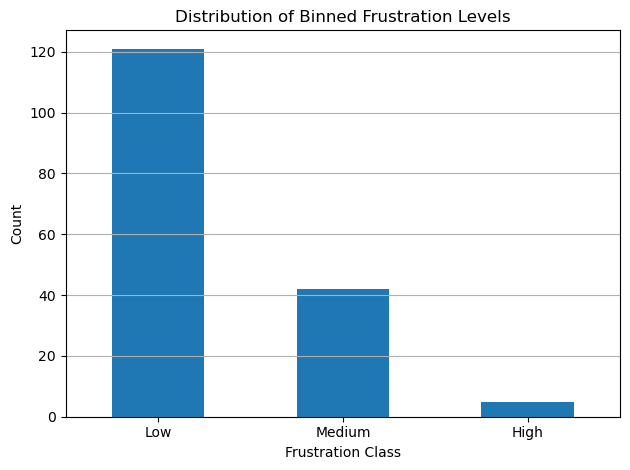

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Bin the raw frustration scores into 3 classes
def bin_frustration(val):
    if val <= 3:
        return 0  # Low
    elif val <= 6:
        return 1  # Medium
    else:
        return 2  # High

# Apply binning
df["Frustration_binned"] = df["Frustrated"].apply(bin_frustration)

# Step 2: Count the number in each bin
binned_counts = df["Frustration_binned"].value_counts().sort_index()

# Step 3: Plot
binned_counts.plot(kind='bar')
plt.xticks(ticks=range(3), labels=["Low", "Medium", "High"], rotation=0)
plt.xlabel("Frustration Class")
plt.ylabel("Count")
plt.title("Distribution of Binned Frustration Levels")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [ ]:
binned_counts.plot(kind='bar')
plt.xticks(ticks=range(3), labels=[str(i) for i in range(3)], rotation=0)
plt.xlabel("Frustration Level (Binned)")
plt.ylabel("Count")
plt.title("Distribution of Frustration Levels")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

CI through bootstrapping:

c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcula

Observed RMSE: 2.311


c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Bruger\Miniconda3\hpython\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcula

95% CI for RMSE: (1.955, 2.788)


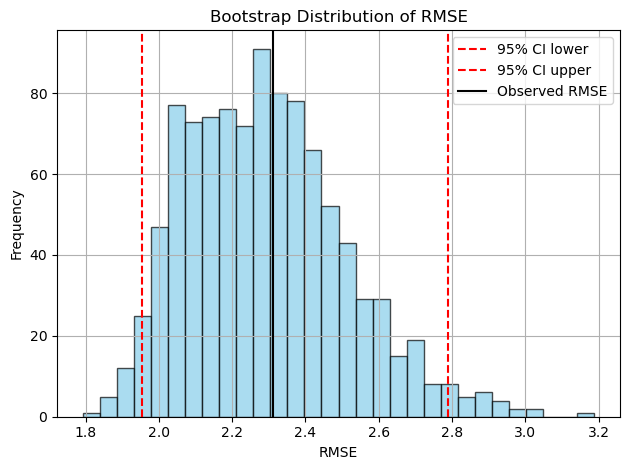

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv("HR_data.csv")
df.columns = df.columns.str.strip()
X = df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max']]
y = df["Frustrated"]
groups = df["Individual"]

# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Group-aware train-test split ---
unique_ids = groups.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_idx = df[groups.isin(train_ids)].index
test_idx = df[groups.isin(test_ids)].index

X_train, y_train = X_scaled[train_idx], y.iloc[train_idx]
X_test, y_test = X_scaled[test_idx], y.iloc[test_idx]

# --- Train model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Calculate observed RMSE ---
rmse_obs = mean_squared_error(y_test, y_pred, squared=False)
print(f"Observed RMSE: {rmse_obs:.3f}")

# --- Bootstrap the RMSE ---
n_bootstraps = 1000
rng = np.random.RandomState(42)
rmse_samples = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y_test), size=len(y_test), replace=True)
    y_test_sample = y_test.iloc[indices]
    y_pred_sample = y_pred[indices]
    rmse = mean_squared_error(y_test_sample, y_pred_sample, squared=False)
    rmse_samples.append(rmse)

# --- Confidence Interval ---
ci_lower = np.percentile(rmse_samples, 2.5)
ci_upper = np.percentile(rmse_samples, 97.5)

print(f"95% CI for RMSE: ({ci_lower:.3f}, {ci_upper:.3f})")

# --- Optional: Plot the bootstrap distribution ---
plt.hist(rmse_samples, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI lower')
plt.axvline(ci_upper, color='red', linestyle='--', label='95% CI upper')
plt.axvline(rmse_obs, color='black', linestyle='-', label='Observed RMSE')
plt.title("Bootstrap Distribution of RMSE")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
